# Scar

In [1]:
import numpy as np 
import scipy as sp

import matplotlib.pyplot as plt


import os, sys
rootpath = os.path.join(os.getcwd(), '..')

sys.path.append(rootpath)


from scipy.sparse import diags, coo_matrix
from scipy import sparse
import jax.numpy as jnp
from diffrax import diffeqsolve, ODETerm, SaveAt
import diffrax
import jax
from jax import lax, vmap, jit
import jax.random as random
from jax.experimental import sparse
from matplotlib.animation import FuncAnimation, PillowWriter



In [2]:


def laplacian_with_scar(N, M, conduction_block_threshold, m, sparse_matrix=True, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Add conduction blocks on the central column
    central_col = M // 2
    middle_row = N // 2
    top_start = max(0, middle_row - m // 2)
    bottom_end = min(N, middle_row + (m + 1) // 2)

    for row in range(top_start, bottom_end):
        conduction_blocks[row, central_col] = True

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, 0.5),  # up
        (1, 0, 0.5),  # down
        (0, -1, 0.5),  # left
        (0, 1, 0.5),  # right
        (-1, -1, 0.25),  # top-left
        (-1, 1, 0.25),  # top-right
        (1, -1, 0.25),  # bottom-left
        (1, 1, 0.25),  # bottom-right
    ]

    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

        # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)

        # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

        # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

        # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))

    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    if sparse_matrix:
        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    else:
        return laplacian_matrix.todense(), conduction_blocks


In [3]:

def FHN_step(u, v, N, a, b, e, Du, sigma, L, key, delta_t):
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - Du: Diffusion coefficient
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) - Du * (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N, y0='wave', a=3, b=0.05, e=1e-2, Du=0.04, L=None, c1=None, sigma=0.0001, stimulus_time=1000, delta_t=0.1, total_time=3000.0, Nconf=3000, key=random.PRNGKey(2)):
    indices = jnp.where((jnp.arange(N) % 200 == 0) & (c1.flatten() == 0))[0]
    if y0 == 'wave':
        y0 = jnp.zeros(2 * N, dtype=jnp.float32)
        y0 = y0.at[indices].set(0.1)

    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)
    save_interval = num_steps // Nconf
    
    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    def scan_fn(carry, step):
        u, v, key, save_counter, u_saved, v_saved = carry
        key, subkey = random.split(key)
        
        # Apply stimulus to the specified indices
        u = jax.lax.cond((step > 0) & (step % int(stimulus_time / delta_t) == 0),
                          lambda u: u.at[indices].add(0.1),
                          lambda u: u,
                          u)

        u, v = FHN_step(u, v, N, a, b, e, Du, sigma, L, subkey, delta_t)
        
        # Save the configuration at the specified intervals
        save_counter = save_counter + 1
        u_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda u_saved: u_saved.at[save_counter // save_interval - 1].set(u),
                               lambda u_saved: u_saved,
                               u_saved)
        v_saved = jax.lax.cond(save_counter % save_interval == 0,
                               lambda v_saved: v_saved.at[save_counter // save_interval - 1].set(v),
                               lambda v_saved: v_saved,
                               v_saved)
        
        return (u, v, key, save_counter, u_saved, v_saved), (u, v)

    # Preallocate arrays for saved configurations
    u_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    v_saved = jnp.zeros((Nconf, N), dtype=jnp.float32)
    
    # Create a range of steps
    steps = jnp.arange(num_steps)
    
    # Run the scan function
    carry = (u, v, key, 0, u_saved, v_saved)
    carry, _ = lax.scan(scan_fn, carry, steps)

    u_saved = carry[4]
    v_saved = carry[5]

    return u_saved, v_saved

In [3]:
def laplacian_with_scar(N, M, conduction_block_threshold, m, sparse_matrix=True, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Add conduction blocks on the central column and its neighbors
    central_col = M // 2
    middle_row = N // 2
    top_start = max(0, middle_row - m // 2)
    bottom_end = min(N, middle_row + (m + 1) // 2)

    # Define the columns to be blocked: central column and its neighbors
    columns_to_block = [central_col - 1, central_col, central_col + 1]
    columns_to_block = [col for col in columns_to_block if 0 <= col < M]  # Ensure in-bounds

    for col in columns_to_block:
        for row in range(top_start, bottom_end):
            conduction_blocks[row, col] = True

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, 0.5),  # up
        (1, 0, 0.5),  # down
        (0, -1, 0.5),  # left
        (0, 1, 0.5),  # right
        (-1, -1, 0.25),  # top-left
        (-1, 1, 0.25),  # top-right
        (1, -1, 0.25),  # bottom-left
        (1, 1, 0.25),  # bottom-right
    ]

    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

        # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)

        # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

        # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

        # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))

    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    if sparse_matrix:
        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    else:
        return laplacian_matrix.todense(), conduction_blocks


In [8]:

#nine columns
def laplacian_with_scar(N, M, conduction_block_threshold, m, sparse_matrix=True, seed=0):
    num_nodes = N * M
    adj_rows = []
    adj_cols = []
    adj_data = []

    # Generate random conduction blocks
    np.random.seed(seed)
    conduction_blocks = np.random.rand(N, M) < conduction_block_threshold

    # Add conduction blocks on the central column and its neighbors
    central_col = M // 2
    middle_row = N // 2
    top_start = max(0, middle_row - m // 2)
    bottom_end = min(N, middle_row + (m + 1) // 2)

    # Add blocks in a 3x3 grid around the central column
    for d_col in [-4,-3,-2,-1, 0, 1, 2,3,4]:  # Central column and its left/right neighbors
        for d_row in [-1, 0, 1]:  # Middle row and its top/bottom neighbors
            col = central_col + d_col
            row_start = max(0, middle_row + d_row - m // 2)
            row_end = min(N, middle_row + d_row + (m + 1) // 2)
            if 0 <= col < M:  # Ensure column is within bounds
                for row in range(row_start, row_end):
                    conduction_blocks[row, col] = True

    # Function to map grid (i, j) to a single node index
    def node_index(i, j):
        return i * M + j

    # Define neighbors for the nine-point stencil with weights
    neighbors = [
        (-1, 0, 0.5),  # up
        (1, 0, 0.5),  # down
        (0, -1, 0.5),  # left
        (0, 1, 0.5),  # right
        (-1, -1, 0.25),  # top-left
        (-1, 1, 0.25),  # top-right
        (1, -1, 0.25),  # bottom-left
        (1, 1, 0.25),  # bottom-right
    ]

    # Build adjacency structure excluding conduction blocks
    indices = np.array([[i, j] for i in range(N) for j in range(M)])
    idx = node_index(indices[:, 0], indices[:, 1])

    for di, dj, weight in neighbors:
        ni = indices[:, 0] + di
        nj = indices[:, 1] + dj

        # Step 1: Filter for in-bounds neighbors
        in_bounds = (ni >= 0) & (ni < N) & (nj >= 0) & (nj < M)

        # Step 2: Find valid indices (in-bounds) to avoid shape mismatches
        valid_indices = np.where(in_bounds)[0]
        ni_valid = ni[valid_indices]
        nj_valid = nj[valid_indices]

        # Step 3: Apply conduction block exclusion on the filtered indices
        valid_conduction = ~conduction_blocks[ni_valid, nj_valid]
        valid_node = ~conduction_blocks[indices[valid_indices, 0], indices[valid_indices, 1]]
        valid = valid_conduction & valid_node

        # Step 4: Append data for fully valid connections
        adj_rows.extend(idx[valid_indices][valid])
        adj_cols.extend(node_index(ni_valid[valid], nj_valid[valid]))
        adj_data.extend([weight] * int(np.sum(valid)))

    # Create adjacency and degree matrices
    adj_matrix = coo_matrix((adj_data, (adj_rows, adj_cols)), shape=(num_nodes, num_nodes))
    degrees = np.array(adj_matrix.sum(axis=1)).flatten()
    degree_matrix = diags(degrees)

    # Construct Laplacian matrix
    laplacian_matrix = degree_matrix - adj_matrix

    if sparse_matrix:
        return sparse.BCSR.from_scipy_sparse(laplacian_matrix), jnp.array(conduction_blocks)
    else:
        return laplacian_matrix.todense(), conduction_blocks


In [15]:
N=200*200
N_x=200
N_y=200
L1, c1 = laplacian_with_scar(N_x, N_x, conduction_block_threshold=0.37,m=0, sparse_matrix=True, seed=200)
u_sol, v_sol = run_simulation(N=N, sigma=0.0001,L=L1, c1=c1, key=random.PRNGKey(2),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=400)
L2, c2 = laplacian_with_scar(N_x, N_x, conduction_block_threshold=0.37, m=150, sparse_matrix=True, seed=200)
u_sol2, v_sol2 = run_simulation(N=N, sigma=0.0001,L=L2, c1=c2, key=random.PRNGKey(2),delta_t=0.1, total_time=6500, stimulus_time=1300, Nconf=400)



In [16]:
def create_movie_from_array(array, output_file="movie.mp4", fps=10, frame_skip=5):
    """
    Create a movie from a 3D array of shape (N, N, T).

    Parameters:
        array (numpy.ndarray): Input array of shape (N, N, T).
        output_file (str): Filename for the output movie (e.g., movie.gif).
        fps (int): Frames per second for the movie.
        frame_skip (int): Number of frames to skip to speed up the movie.
    """
    N, _, T = array.shape  # Extract dimensions
    fig, ax = plt.subplots()
    
    # Display the first frame
    img = ax.imshow(array[:, :, 0], cmap="seismic", interpolation="bilinear", vmin=-np.max(np.abs(array)), vmax=np.max(np.abs(array)), aspect='auto')
    #plt.axis("off")
    
    # Add a colorbar
    cbar = fig.colorbar(img, ax=ax)
    cbar.set_label('V', rotation=0, labelpad=15, fontsize=12, color='black')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  
    
    
    # Update function for the animation
    # Add contours to the plot
    '''
    def add_contours():
        ax.contour(array[:, :, 0], colors='black', linewidths=0.5)
    
    add_contours()
    '''
    def update(frame):
        img.set_data(array[:, :, frame])
        return img,

    # Create the animation with skipped frames
    frames = range(0, T, frame_skip)
    anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=True)
    
    # Save as GIF or MP4
    if output_file.endswith(".gif"):
        anim.save(output_file, writer=PillowWriter(fps=fps))
    elif output_file.endswith(".mp4"):
        anim.save(output_file, writer="ffmpeg", fps=fps)
    else:
        raise ValueError("Output file must end with .gif or .mp4")
    
    plt.close(fig)
    print(f"Movie saved to {output_file}")


u_sol2=u_sol2.T
u_sol2=u_sol2.reshape(N_x,N_y, -1)
u_sol=u_sol.T
u_sol=u_sol.reshape(N_x, N_y, -1)

create_movie_from_array(u_sol2, output_file="simulation_p=0.37_scar.gif", fps=100, frame_skip=1)
create_movie_from_array(u_sol,output_file="simulation_p=0.37_noscar.gif", fps=100, frame_skip=1 )

Movie saved to simulation_p=0.37_scar.gif
Movie saved to simulation_p=0.37_noscar.gif


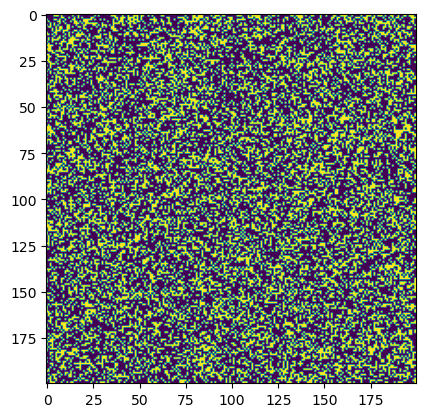

In [6]:
plt.imshow(c1)

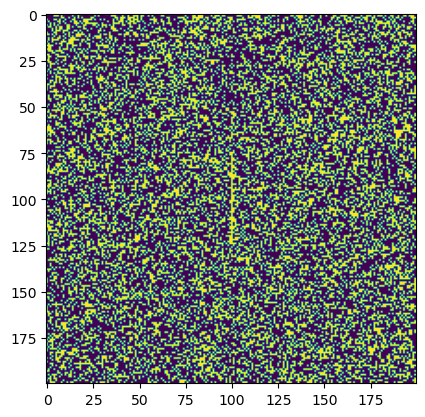

In [7]:
plt.imshow(c2)

In [4]:
#normalised entropy
#normalised entropy

def calculate_entropy_jax(binary_arrays, s, size=None):
    """
    Calculate the entropy of the patterns contained in a set of binary arrays,
    normalizing the probability mass to 1 by adjusting unobserved probabilities.

    Parameters:
        binary_arrays (jax.numpy.ndarray): A 2D array of binary arrays (N, T).
        s (int): The length of each binary array.
        size (int, optional): The maximum number of unique patterns to consider.

    Returns:
        tuple: A tuple containing:
            - float: The entropy of the binary arrays.
            - float: The normalized entropy of the binary arrays.
            - int: The length of each binary array.
    """
    # Calculate the number of unique patterns and their counts
    unique_patterns, counts = jnp.unique(binary_arrays, axis=1, return_counts=True, size=size)
    total_patterns = jnp.sum(counts)  # Total count of all observed patterns

    # Total possible patterns (2^s)
    num_possible_patterns = 2 ** s

    # Compute raw probabilities for observed patterns (Laplace smoothing)
    probabilities_observed = (counts + 1) / (total_patterns + num_possible_patterns)

    # Compute the total probability mass for observed patterns
    total_probability_mass_observed = jnp.sum(probabilities_observed)

    # Number of unobserved patterns
    num_observed_patterns = counts.size
    num_unobserved_patterns = num_possible_patterns - num_observed_patterns

    # Compute the remaining probability mass for unobserved patterns
    remaining_probability_mass = 1 - total_probability_mass_observed

    # Distribute this mass uniformly among unobserved patterns
    probability_unobserved = remaining_probability_mass / num_unobserved_patterns
   
    # Compute the entropy contribution from observed patterns
    entropy_observed = -jnp.sum(probabilities_observed * jnp.log2(probabilities_observed))

    # Compute the entropy contribution from unobserved patterns
    entropy_unobserved = -num_unobserved_patterns * probability_unobserved * jnp.log2(probability_unobserved)

    # Total entropy
    entropy = entropy_observed + entropy_unobserved

    # Normalize entropy
    max_entropy = s  # Maximum entropy for binary arrays of length s
    normalized_entropy = entropy / max_entropy

    return entropy, normalized_entropy



In [9]:
def entropycalc(array, s):
    threshold = 0.08
    binary_u = jnp.where(array > threshold, 1, 0)
    print(binary_u.shape)
    binary_u=binary_u.reshape(s**2, -1)
    binary_u=binary_u[:, 1300:]
    entropy, normalised=calculate_entropy_jax(binary_u,s*s, 1)
    return entropy, normalised

In [26]:
from jax import lax

def split_and_calculate_entropy(array, frame_size=4):
    """
    Splits the input array into smaller frames of size (frame_size, frame_size, T)
    and calculates the entropy for each frame using the entropycalc function.
    
    Parameters:
        array (jnp.ndarray): Input array of shape (192, 192, T).
        frame_size (int): Size of the smaller frames. Default is 4.
        
    Returns:
        jnp.ndarray: Array of entropies for each frame.
        jnp.ndarray: Array of normalized entropies for each frame.
    """
    N, _, T = array.shape
    num_frames = (N // frame_size) ** 2


    def calculate_entropy_for_frame(i, j):
        
        frame = lax.dynamic_slice(array, (i, j, 0), (frame_size, frame_size, T))
        return entropycalc(frame, frame_size)

    indices = jnp.arange(0, N, frame_size)
    
    entropies, normalized_entropies = vmap(
        lambda i: vmap(lambda j: calculate_entropy_for_frame(i, j))(indices)
    )(indices)
    print(entropies)
    return jnp.mean(entropies), jnp.mean(normalized_entropies)

# Example usage
# Example usage
array = random.normal(random.PRNGKey(0), (9, 9, 6500))
entropies, normalized_entropies = split_and_calculate_entropy(array, 3)
print(entropies)
print(normalized_entropies)


(3, 3, 6500)
[[8.941619  8.948412  8.9275055]
 [8.873925  8.873925  8.905236 ]
 [8.897564  8.897564  8.897564 ]]
8.907035
0.9896706


In [19]:
array=array.reshape(16, 65000)
entropy, norm =calculate_entropy_jax(array, 16)
print(entropy, norm)

9.032703 0.56454396
